### This is how I got into top 2% in Kaggle House Price Prediction Competition just using the cleaned data and one simple model.

- The model is built on top of cleaned dataset which you can get from this link : https://www.kaggle.com/chandramoulinaidu/house-price-prediction-cleaned-dataset
- This dataset is accurately tailored for model fitting.
- Description for this problem : https://www.kaggle.com/c/home-data-for-ml-course
- Evaluation is based on RMSE

### This is a regression problem with many features, so will focus on only two concepts 
- How to fix overfitting.
- Which model to choose (Lasso, Ridge, ElasticNet)

In [23]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from warnings import filterwarnings
filterwarnings('ignore')

/kaggle/input/house-price-prediction-cleaned-dataset/Cleaned train.csv
/kaggle/input/house-price-prediction-cleaned-dataset/Info.txt
/kaggle/input/house-price-prediction-cleaned-dataset/Cleaned test.csv


#### Importing Packages

In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import ElasticNet


from sklearn.model_selection import GridSearchCV

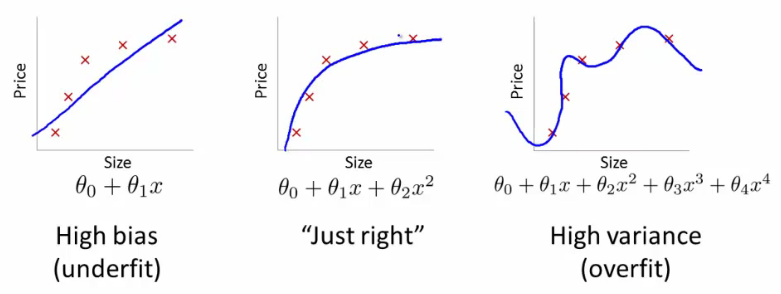

#### From above image we can see 3 situations 
- 1) Under fit (High Bias: Model fails to recognise pattern for given features) : This Happens when dataset contains very less features.
- 2) Over fit (High Variance: Model does good with train set but bad with test set) : This Happens when dataset contains more features.
- 3) Correct fit : Low Bias and Low Variance

#### Since House price prediction problem contains more features, it will be definitely overfitting problem.
#### Regularization : To fix overfitting
- In regularization, what we do is normally we keep the same number of features, but reduce the magnitude of the coefficients by value alpha vlaue(regularization parameter , Lambda in above image).
- This alpha will minimize the coefficients of the features and reduce the model complexity.
- Since Normal Linear Regression does not have this alpha parameter we will be switching to other algorithm.

#### Algorithms:
- Lasso (L1) Uses L1 to minimize coefficient very near to 0 (almost negligible).
- Ridge (L2) Uses L2 to minimize coefficient to some extent.
- ElasticNet (Boht L1 and L2)

We will be using ElasticNet

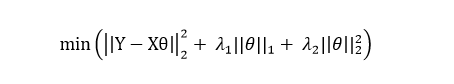

Here $ \lambda_1$ --> L1, $ \lambda_2$ --> L2

In [25]:
# Loading Datasets

train  = pd.read_csv("../input/house-price-prediction-cleaned-dataset/Cleaned train.csv")
test = pd.read_csv("../input/house-price-prediction-cleaned-dataset/Cleaned test.csv")

In [26]:
train.head()

Id  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0   1    18.144573  13.833054            7     3.991517       2003   
1   2    20.673625  14.117918            6     6.000033       1976   
2   3    18.668047  14.476512            7     3.991517       2001   
3   4    17.249651  14.106196            7     3.991517       1915   
4   5    21.314283  15.022008            8     3.991517       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_New  \
0          2003   19.433175  144.117862         0.0  ...             0   
1          1976   54.598150  181.719186         0.0  ...             0   
2          2002   17.768840  110.441033         0.0  ...             0   
3          1970   54.598150   61.795315         0.0  ...             0   
4          2000   25.404164  136.624601         0.0  ...             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  Saleprice  
0                      0   208501.0  
1                      0   181501.0  
2                      0   223501.0  
3                      0   140001.0  
4                      0   250001.0  

[5 rows x 380 columns]

In [27]:
train.shape

(1458, 380)

In [28]:
test.head()

Id  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0  1461    20.673625  14.550687            5     4.679501       1961   
1  1462    20.834996  15.023149            6     4.679501       1958   
2  1463    19.687482  14.950918            5     3.991517       1997   
3  1464    20.348384  14.204772            6     4.679501       1998   
4  1465    13.949261  12.696875            8     3.991517       1992   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0          1961   54.598150  107.505912    7.760721  ...               0   
1          1958   14.642918  174.393644    0.000000  ...               0   
2          1998   54.598150  156.263694    0.000000  ...               0   
3          1998    6.157403  128.653472    0.000000  ...               0   
4          1992   54.598150   71.179547    0.000000  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      0   
4             0             0            1                      0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     1                      0  
4                     1                      0  

[5 rows x 379 columns]

In [29]:
test.shape

(1459, 379)

In [30]:
# transforming SalePrice with log(1+x)

train["Saleprice"] = np.log(train["Saleprice"])
price = train["Saleprice"]
train.drop(['Saleprice','Id'], axis=1, inplace=True)
test_id = test['Id']
test.drop('Id', axis=1, inplace=True)

In [31]:
kf = KFold(n_splits=12, shuffle=True, random_state=42)

In [32]:
# Using Cross_validation_Score to get Root mean square error

def cv_rmse(model):
    
    return np.sqrt(-cross_val_score(model, train, price, scoring="neg_mean_squared_error", cv=kf)).mean()
    

In [33]:
# Evaluating model with default parameters and check the rmse value
elastic_net = ElasticNet()

In [34]:
print("RMSE with default parameters :",cv_rmse(elastic_net))

RMSE with default parameters : 0.17519749831464346


In [35]:
# Lets tune Parameters
alpha = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]
l1_ratio = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]

params = {"alpha":alpha,"l1_ratio":l1_ratio}

In [36]:
grid_cv = GridSearchCV(estimator=elastic_net,
                       param_grid=params,
                       cv=kf,
                       refit=True,
                       verbose=1)
                       

In [37]:
# Fitting the gridsearchcv model and get the best parameters

grid_cv.fit(train,price)


Fitting 12 folds for each of 121 candidates, totalling 1452 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1452 out of 1452 | elapsed:  5.4min finished


GridSearchCV(cv=KFold(n_splits=12, random_state=42, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,
                                   50, 100],
                         'l1_ratio': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5,
                                      10, 50, 100]},
             verbose=1)

In [38]:
grid_cv.best_score_, grid_cv.best_params_

(0.9253241732844127, {'alpha': 0.001, 'l1_ratio': 0.5})

In [39]:
# Redefining model with above parameter values

elastic_net = ElasticNet(alpha=0.001, l1_ratio=0.5).fit(train,price)
cv_rmse(elastic_net)

0.10783460477814706

In [41]:
# SalePrice is in log, we need to Convert it back to actual price by taking exponential using np.e

submission = pd.DataFrame({"Id":test_id,"SalePrice":np.e**elastic_net.predict(test)})

In [42]:
submission.to_csv("Submission.csv", index=False)

Id      SalePrice
0  1461  120939.470615
1  1462  155534.926657
2  1463  183215.693315
3  1464  200303.847074
4  1465  195178.807891